In [46]:
import sys
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [47]:
"""
Dimensions need to be checked between n_users. n_items and X before calling this
"""

class Bias_UV(nn.Module):
  
    def __init__(self, n_users, n_items, nan_map, rand_init=True, max_bias=3, min_bias=0, dim=8):
        super().__init__()
        torch.manual_seed(0)
        self.user_bias = nn.Parameter(torch.zeros(n_users))
        self.item_bias = nn.Parameter(torch.zeros(n_items))
        self.nan_map = nan_map
        self.U = nn.Parameter(torch.zeros(n_users, dim))
        self.V = nn.Parameter(torch.zeros(n_items, dim))
        if rand_init:
            nn.init.uniform_(self.user_bias, min_bias, max_bias)
            nn.init.uniform_(self.item_bias, min_bias, max_bias)
            nn.init.uniform_(self.U)
            nn.init.uniform_(self.V)
    
    def forward(self, X):
        y_pred_bias = torch.cartesian_prod(self.user_bias, self.item_bias).sum(-1).view(len(self.user_bias), len(self.item_bias))
        y_pred_UV = self.U @ self.V.t()
        y_pred = y_pred_bias + y_pred_UV
        y_pred = torch.where(self.nan_map, torch.zeros_like(y_pred), y_pred)
        return y_pred
        

In [48]:
def fit_v1(interaction_matrix, model, nan_map, epochs = 50, learning_rate = 0.6, wt_decay=1e-7):
    loss_arr = []
    opt = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wt_decay)
    
    X_train = torch.where(nan_map, torch.zeros_like(interaction_matrix), interaction_matrix)
    
    for epoch in range(epochs):
        y_hat = model(X_train)
        loss = F.mse_loss(y_hat, X_train)
        print("Epoch # {} --> mse_loss: {}".format(epoch, loss.item()))
        loss_arr.append(loss.item())

        loss.backward()
        opt.step()
        opt.zero_grad()


    plt.plot(loss_arr, 'r-')
    plt.show()      
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])

In [49]:
torch.set_default_tensor_type(torch.DoubleTensor)

import dill

load_path = "file_server/processed_data/iteration1/magazine_subscription_subset_115X18241/"

# train_matrix
train_matrix = dill.load(open(load_path+"train_matrix.pkl", "rb"))

# train_users
train_users = dill.load(open(load_path+"train_users.pkl", "rb"))

# items (common for train and test)
items = dill.load(open(load_path+"items.pkl", "rb"))

# test_matrix
test_matrix = dill.load(open(load_path+"test_matrix.pkl", "rb"))

# test_users
test_users = dill.load(open(load_path+"test_users.pkl", "rb"))

In [50]:
# Convert train_matrix to torch tensor and calc n_users and n_items
train_matrix = torch.from_numpy(train_matrix)

# Create nan_map, get n_users and n_items
nan_mp = torch.isnan(train_matrix)
n_users, n_items = len(train_users), len(items)

Epoch # 0 --> mse_loss: 0.04886933910675878
Epoch # 1 --> mse_loss: 0.053664038694083774
Epoch # 2 --> mse_loss: 0.024397090116737748
Epoch # 3 --> mse_loss: 0.021824059562493725
Epoch # 4 --> mse_loss: 0.011176906338577743
Epoch # 5 --> mse_loss: 0.013432903873124034
Epoch # 6 --> mse_loss: 0.010715691674056107
Epoch # 7 --> mse_loss: 0.009161930811875727
Epoch # 8 --> mse_loss: 0.007572552025714524
Epoch # 9 --> mse_loss: 0.006644678929231863
Epoch # 10 --> mse_loss: 0.005317649373798961
Epoch # 11 --> mse_loss: 0.00437774032866513
Epoch # 12 --> mse_loss: 0.004231921453456633
Epoch # 13 --> mse_loss: 0.0038658634347077682
Epoch # 14 --> mse_loss: 0.0033650302903575026
Epoch # 15 --> mse_loss: 0.0028541013926338846
Epoch # 16 --> mse_loss: 0.0025653865422889397
Epoch # 17 --> mse_loss: 0.0022323340404556825
Epoch # 18 --> mse_loss: 0.0019125627303480846
Epoch # 19 --> mse_loss: 0.0017394362948195104
Epoch # 20 --> mse_loss: 0.0015500325640158902
Epoch # 21 --> mse_loss: 0.00136961882

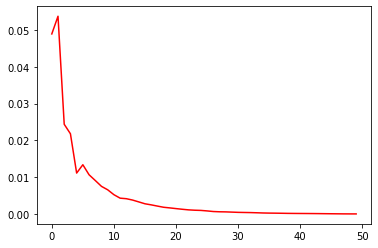

Loss before training 0.04886933910675878
Loss after training 0.00010961389840228401
CPU times: user 20.5 s, sys: 30.9 s, total: 51.5 s
Wall time: 3.31 s


In [51]:
%%time
# create and fit the model
model_v3 = Bias_UV(n_users=n_users, n_items=n_items, nan_map=nan_mp, dim=10)
fit_v1(interaction_matrix=train_matrix, nan_map=nan_mp, model=model_v3)

In [52]:
# create completed matrix
bias_part = torch.cartesian_prod(model_v3.user_bias, model_v3.item_bias).sum(-1).view(len(model_v3.user_bias), len(model_v3.item_bias))
uv_part = model_v3.U @ model_v3.V.t()
completed_matrix = bias_part + uv_part
# replace original training values using nan_mp
completed_matrix = torch.where(nan_mp, completed_matrix, train_matrix).detach().numpy()

In [53]:
# get index of users in train set who are present in test set
common_user_indices = np.argwhere(np.in1d(train_users, test_users))

In [54]:
def pointwise_mad_between_1darrays(arr1, arr2):
    """
    This function returns a np.array of (index, mad_value) tuple, 
    index signifying which index at both arrays were used to compute the value.
    If either of the arrays have NaN value at any given index, then its ignored for computation
    """
    try:
        if len(arr1) != len(arr2):
            raise ValueError("Array lengths should be equal")
        result = list()
        for i in range(len(arr1)):
            if ~np.isnan(arr1[i]) and ~np.isnan(arr2[i]):
                result.append((i, abs(float(arr1[i]) - float(arr2[i]))))
        return np.array(result)
    except Exception as e:
        error_type, error_instance, traceback = sys.exc_info()
        print(arr1, arr2)
        print(error_type, error_instance, traceback)
        

def pointwise_accuracy_ceil_or_floor(true_arr, pred_arr):
    """
    Returns a np.array of (index, accuracy_value) tuple.
    accuracy_val = 1, when true_arr E {ceil(pred_arr), floor(pred_arr)}, 0 otherwise. 
    Missing values in either arrays are discarded for computation
    """
    try:
        if len(true_arr) != len(pred_arr):
            raise ValueError("Array lengths should be equal")
        result = list()
        for i in range(len(true_arr)):
            if ~np.isnan(true_arr[i]) and ~np.isnan(pred_arr[i]):
                if int(true_arr[i]) in [math.floor(float(pred_arr[i])), math.ceil(float(pred_arr[i]))]:
                    result.append((i, 1))
                else:
                    result.append((i, 0))
        return np.array(result)
    except Exception as e:
        error_type, error_instance, traceback = sys.exc_info()
        print(true_arr, pred_arr)
        print(error_type, error_instance, traceback)
    
    
def pointwise_accuracy_ceil_or_floor_add1(true_arr, pred_arr):
    """
    Returns a np.array of (index, accuracy_value) tuple.
    accuracy_val = 1, when true_arr E {ceil(pred_arr) + 1, floor(pred_arr) - 1}, 0 otherwise. 
    Missing values in either arrays are discarded for computation
    """
    try:
        if len(true_arr) != len(pred_arr):
            raise ValueError("Array lengths should be equal")
        result = list()
        for i in range(len(true_arr)):
            if ~np.isnan(true_arr[i]) and ~np.isnan(pred_arr[i]):
                if int(true_arr[i]) in [
                    math.floor(float(pred_arr[i])) - 1 ,
                    math.ceil(float(pred_arr[i])) + 1,
                    math.floor(float(pred_arr[i])),
                    math.ceil(float(pred_arr[i]))
                ]:
                    result.append((i, 1))
                else:
                    result.append((i, 0))
        return np.array(result)
    except Exception as e:
        error_type, error_instance, traceback = sys.exc_info()
        print(true_arr, pred_arr)
        print(error_type, error_instance, traceback)

        
def metrics_collector(test_matrix, pred_matrix, common_indices, metrics='all'):
    metrics_map = {
        'accuracy_ceil_floor_add1': pointwise_accuracy_ceil_or_floor_add1,
        'accuracy_ceil_floor': pointwise_accuracy_ceil_or_floor,
        'mad': pointwise_mad_between_1darrays
    }
    try:
        if metrics!="all":
            raise ValueError("something something meri jaan")
        metrics_vals = {key:np.ones([1,3]) for key in metrics_map.keys()}
        for i in range(len(test_matrix)):
            for metric, func in metrics_map.items():
                _val = func(test_matrix[i], pred_matrix[common_indices[i][0]])
                _val = np.insert(_val, 0, i, axis=1)
                metrics_vals[metric] = np.append(metrics_vals[metric], _val, axis=0)
        return metrics_vals
    except Exception as e:
        error_type, error_instance, traceback = sys.exc_info()
        print(error_type, error_instance, traceback)

In [55]:
metrics = metrics_collector(test_matrix=test_matrix, pred_matrix=completed_matrix, common_indices=common_user_indices)

In [56]:
accuracy_ceil_floor = np.delete(metrics['accuracy_ceil_floor'], 0, 0)[:,2]
np.mean(accuracy_ceil_floor)

0.2965534341681131

In [57]:
accuracy_ceil_floor_add1 = np.delete(metrics['accuracy_ceil_floor_add1'], 0, 0)[:,2]
np.mean(accuracy_ceil_floor_add1)

0.7438631291842301

In [58]:
mad = np.delete(metrics['mad'], 0, 0)[:,2]
np.mean(mad), np.median(mad), np.std(mad)

(1.4941607645001027, 1.3844292166943077, 0.9031946959042594)

## Distribution of mad errors

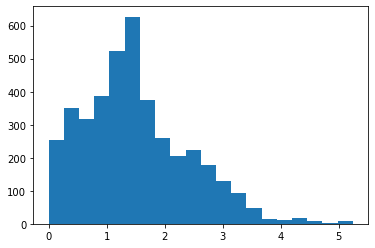

In [59]:
import matplotlib.pyplot as plt

plt.hist(mad, bins=20)
plt.show()

## Plotting weights


In [60]:
import seaborn as sns

item_biases = list(model_v3.parameters())[1].data.numpy()
user_biases = list(model_v3.parameters())[0].data.numpy()
U_values = list(model_v3.parameters())[2].data.numpy()
V_values = list(model_v3.parameters())[3].data.numpy()

[]

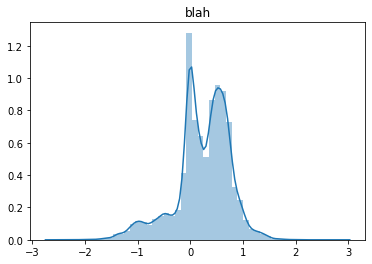

In [61]:
# Item bias plot
sns.distplot(item_biases.ravel()).set_title("blah")
plt.plot()


[]

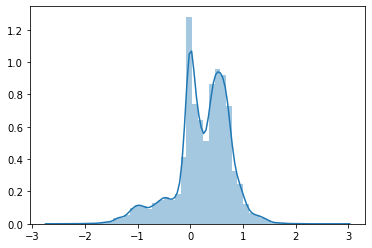

In [62]:
# User bias plot
sns.distplot(item_biases.ravel())
plt.plot()

[]

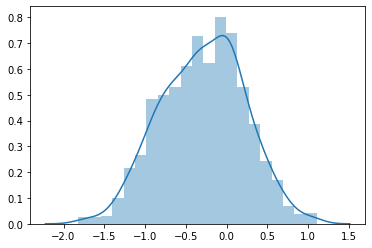

In [63]:
# User factor plot
sns.distplot(U_values.ravel())
plt.plot()

[]

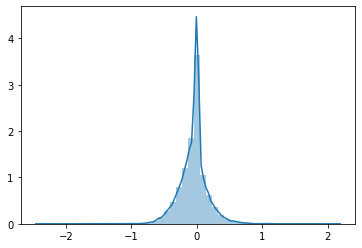

In [64]:
# Item factors plot
sns.distplot(V_values.ravel())
plt.plot()

## Analysis of errors

In [68]:
# we first create a lookup of the 
#     1. no.of products rated by each user
#     2. no.of users who have rated each product

detached_train = train_matrix.detach().numpy()
user_rating_counts = list(map(lambda x: np.count_nonzero(~np.isnan(detached_train[x, :])), range(len(detached_train))))
item_rating_counts = list(map(lambda x: np.count_nonzero(~np.isnan(detached_train[:, x])), range(detached_train.shape[1])))


In [72]:
# No of products that had no ratings in the train, but had one rating in the test (effect of sampling)
len([x for x in item_rating_counts if x==0])

3484

In [71]:
max(user_rating_counts), min(user_rating_counts), max(item_rating_counts), min(item_rating_counts)

(1220, 1, 17, 0)

In [108]:
# get the no of user ratings in log base 10 space

user_rating_counts = np.log10(user_rating_counts)


(4034, 3)
(2837,)


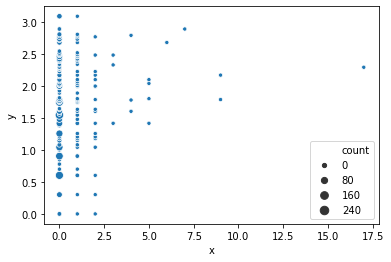

In [126]:
# loop through the errors and create a dataframe with x as product count and y as user count (in log space)

print(metrics['accuracy_ceil_floor'].shape)

# filter errors
errors = metrics['accuracy_ceil_floor'][metrics['accuracy_ceil_floor'][:,2]==0]

# create a vectorizer to map to user and item ratings count from indices
user_count_mapper = np.vectorize(lambda x: user_rating_counts[int(x)])
item_count_mapper = np.vectorize(lambda x: item_rating_counts[int(x)])

print(errors[:,0].shape)

# apply mapper to errors
errors[:,0] = user_count_mapper(errors[:,0])
errors[:,1] = item_count_mapper(errors[:,1])

# create a datframe for with item rating counts as 'x' and log(user rating counts) as 'y'
error_df = pd.DataFrame(errors[:,:2], columns=['y','x'])
error_df = pd.DataFrame({'count' : error_df.groupby( ['x', 'y'] ).size()}).reset_index()

sns.scatterplot(x='x', y='y', size='count', data=error_df).figure.savefig("www.png")

In [104]:
kkt = pd.DataFrame([[2,2],[3,4],[2,2],[3,5]], columns=['x','y'])
kkt

,x,y
0,2,2
1,3,4
2,2,2
3,3,5


In [106]:
kkt = pd.DataFrame({'count' : kkt.groupby( ['x', 'y'] ).size()}).reset_index()


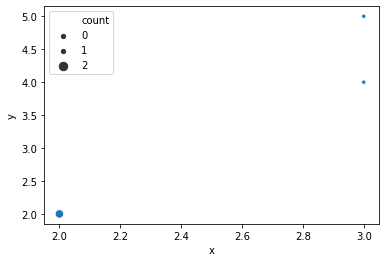

In [107]:
sns.scatterplot(x='x', y='y', size='count', data=kkt)

In [116]:
nn = np.array([[2,2],[3,4],[2,2],[3,5]])
mpp = np.array([200, 300, 400, 500])
w = np.vectorize(lambda x: mpp[x-2])

nn[:,1] = w(nn[:,1])

nn

array([[  2, 200],
       [  3, 400],
       [  2, 200],
       [  3, 500]])

In [131]:
from uuid import uuid4
str(uuid4())+"ka"

'fff45fe4-a932-4e7f-80ce-4de40e58452bka'

In [69]:
def get_products_with_no_ratings(s):
    col_indices = list()
    for i in range(s.shape[1]):
        if np.count_nonzero(~np.isnan(s[:,i]))==0:
            col_indices.append(i)
    return col_indices

print(len(get_products_with_no_ratings(detached_train)))

3484
